In [72]:
# 导入环境的包
import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

from tcn import TCN
from tensorflow.keras.layers import Dense,Dropout,Attention
from tensorflow.keras import Input, Model

In [73]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [74]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [96]:
daily_cases_ = pd.read_csv('new_daily_cases/new_daily_cases_Russia.csv').iloc[:,1:]
df_resample=daily_cases_.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,4434.0
5/11/22,4036.0
5/12/22,4029.0
5/13/22,4832.0


In [97]:
## * Note: 归一化数据范围为0-1.
values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [98]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
n_train_time = 812 #以813天数据训练
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
test_y

(812, 1, 1) (812,) (30, 1, 1) (30,)


array([0.05579815, 0.05386453, 0.04992805, 0.04592727, 0.04214904,
       0.0448937 , 0.04317767, 0.04373155, 0.04288095, 0.04101162,
       0.03723338, 0.03460742, 0.03775759, 0.0373224 , 0.03753505,
       0.03593771, 0.03438982, 0.03027531, 0.0265762 , 0.02484533,
       0.02448927, 0.02694215, 0.0267394 , 0.02653169, 0.02441015,
       0.02192759, 0.01995935, 0.01992473, 0.02389583, 0.02453378])

# 构建TCN-Attention模型

### 1) TCN 卷积个数32，卷积核3等
### 2) Attention为自注意力机制
### 3) dropout 层20%
### 4) 1个神经元在输出层中，用于预测Global_Active_Power。
### 5) 输入形状为1个时间步长，有1个特征

### 6)使用了平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam。
### 7)  epochs=100, batch size = 8.

Epoch 1/100
102/102 - 3s - loss: 0.0036 - val_loss: 1.4719e-04
Epoch 2/100
102/102 - 0s - loss: 0.0034 - val_loss: 4.4186e-04
Epoch 3/100
102/102 - 0s - loss: 0.0016 - val_loss: 5.3122e-04
Epoch 4/100
102/102 - 0s - loss: 0.0014 - val_loss: 3.7799e-04
Epoch 5/100
102/102 - 0s - loss: 0.0025 - val_loss: 6.1823e-04
Epoch 6/100
102/102 - 0s - loss: 9.6639e-04 - val_loss: 8.2627e-05
Epoch 7/100
102/102 - 0s - loss: 0.0012 - val_loss: 1.5286e-04
Epoch 8/100
102/102 - 0s - loss: 8.5144e-04 - val_loss: 5.6586e-05
Epoch 9/100
102/102 - 0s - loss: 0.0015 - val_loss: 2.7747e-04
Epoch 10/100
102/102 - 0s - loss: 0.0015 - val_loss: 2.2705e-05
Epoch 11/100
102/102 - 0s - loss: 0.0014 - val_loss: 4.1148e-05
Epoch 12/100
102/102 - 0s - loss: 0.0037 - val_loss: 0.0019
Epoch 13/100
102/102 - 0s - loss: 0.0026 - val_loss: 2.0255e-04
Epoch 14/100
102/102 - 0s - loss: 0.0028 - val_loss: 0.0018
Epoch 15/100
102/102 - 0s - loss: 0.0030 - val_loss: 7.5784e-05
Epoch 16/100
102/102 - 0s - loss: 0.0056 - val_lo

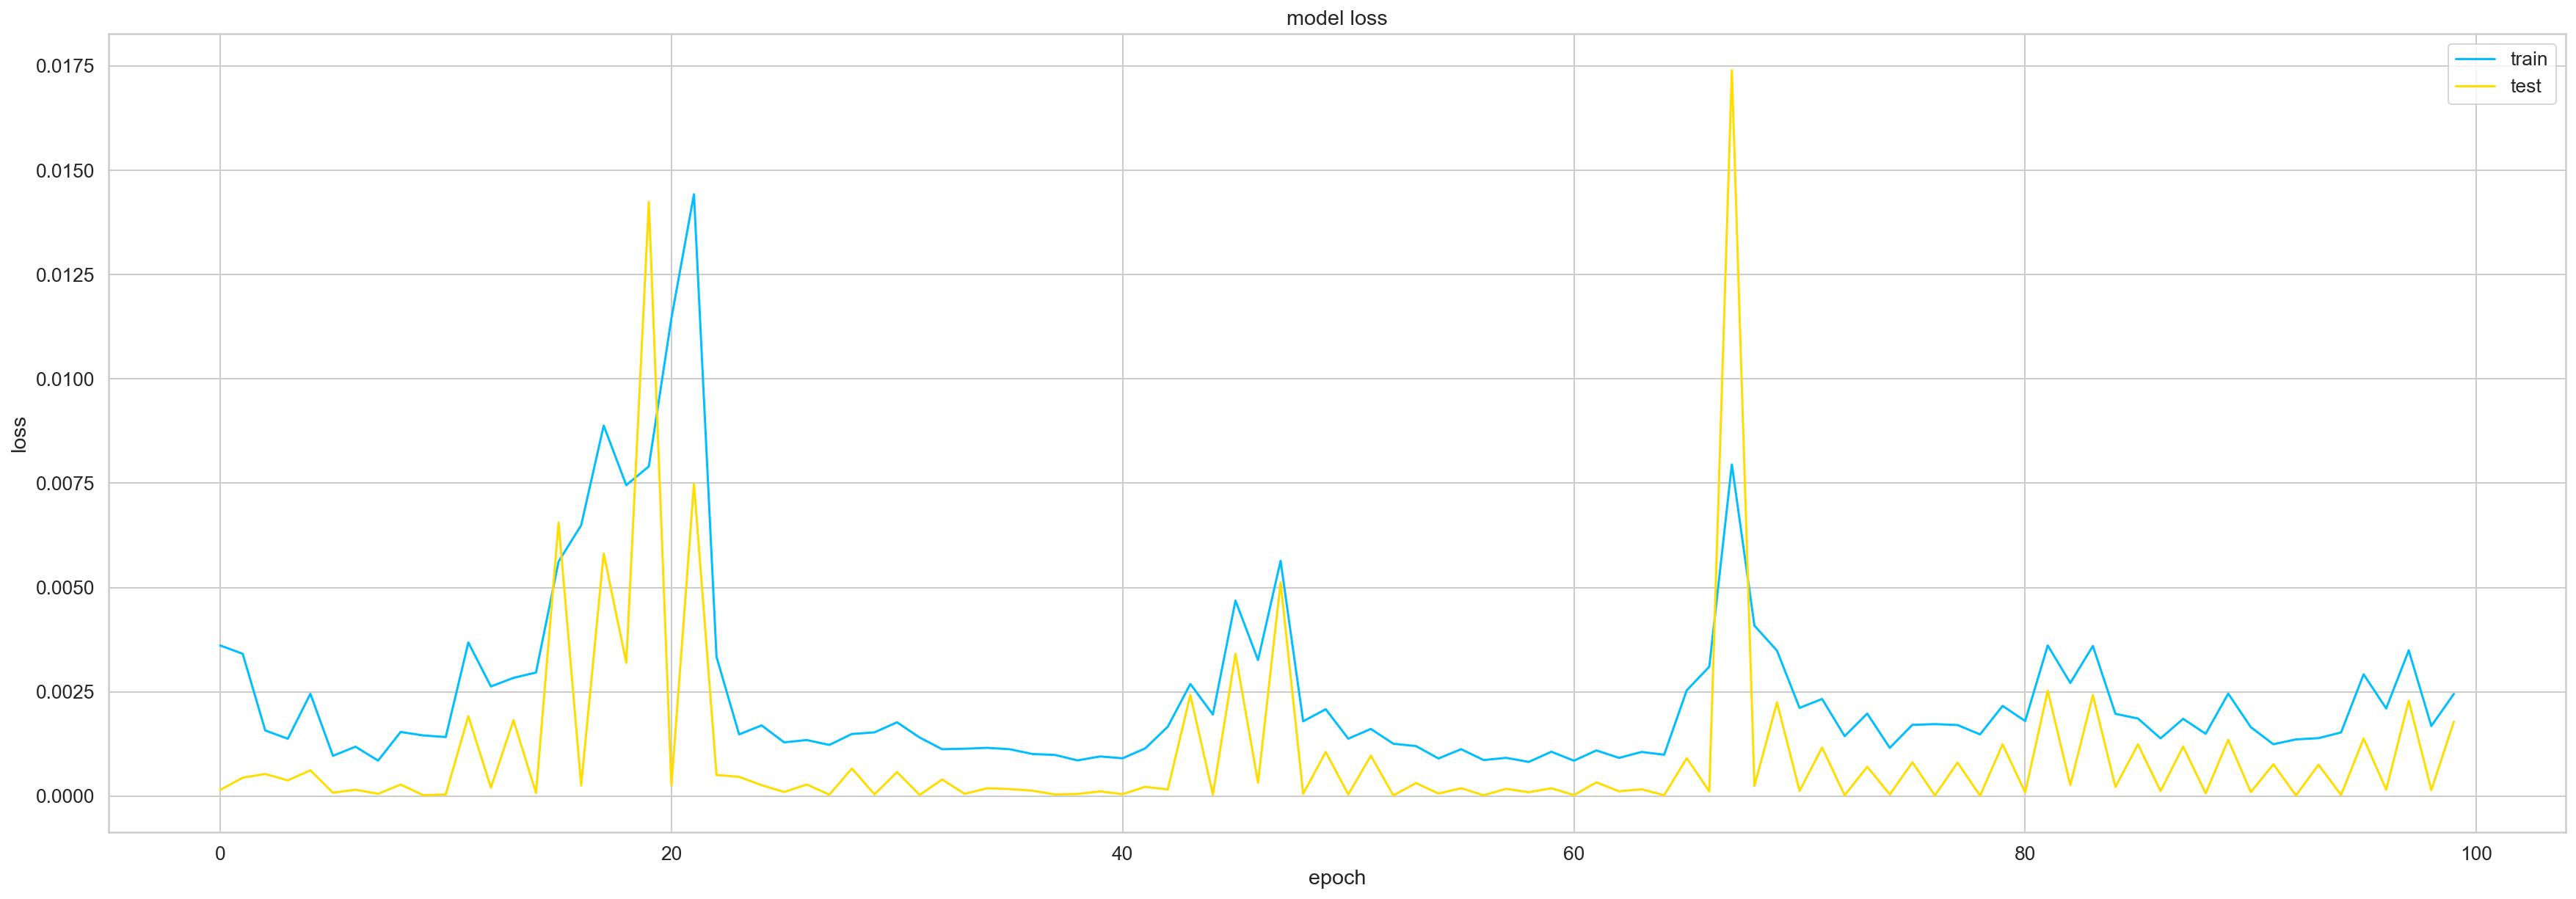

Test RMSE: 8723.8057


In [101]:
#网络结构
inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))  # 构建输入的大小，即张量
tcn_layer = TCN(nb_filters=32,kernel_size=3,padding='causal', dilations=(1, 2, 4, 8,16),input_shape=(train_X.shape[1], train_X.shape[2]))(inputs)
attention_layer=Attention()([tcn_layer,tcn_layer])
dp=Dropout(0.2)(attention_layer)
out_layer = Dense(1, activation='linear')(dp) 
model = Model(inputs=inputs, outputs=out_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:, :]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, :]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.4f' % rmse)

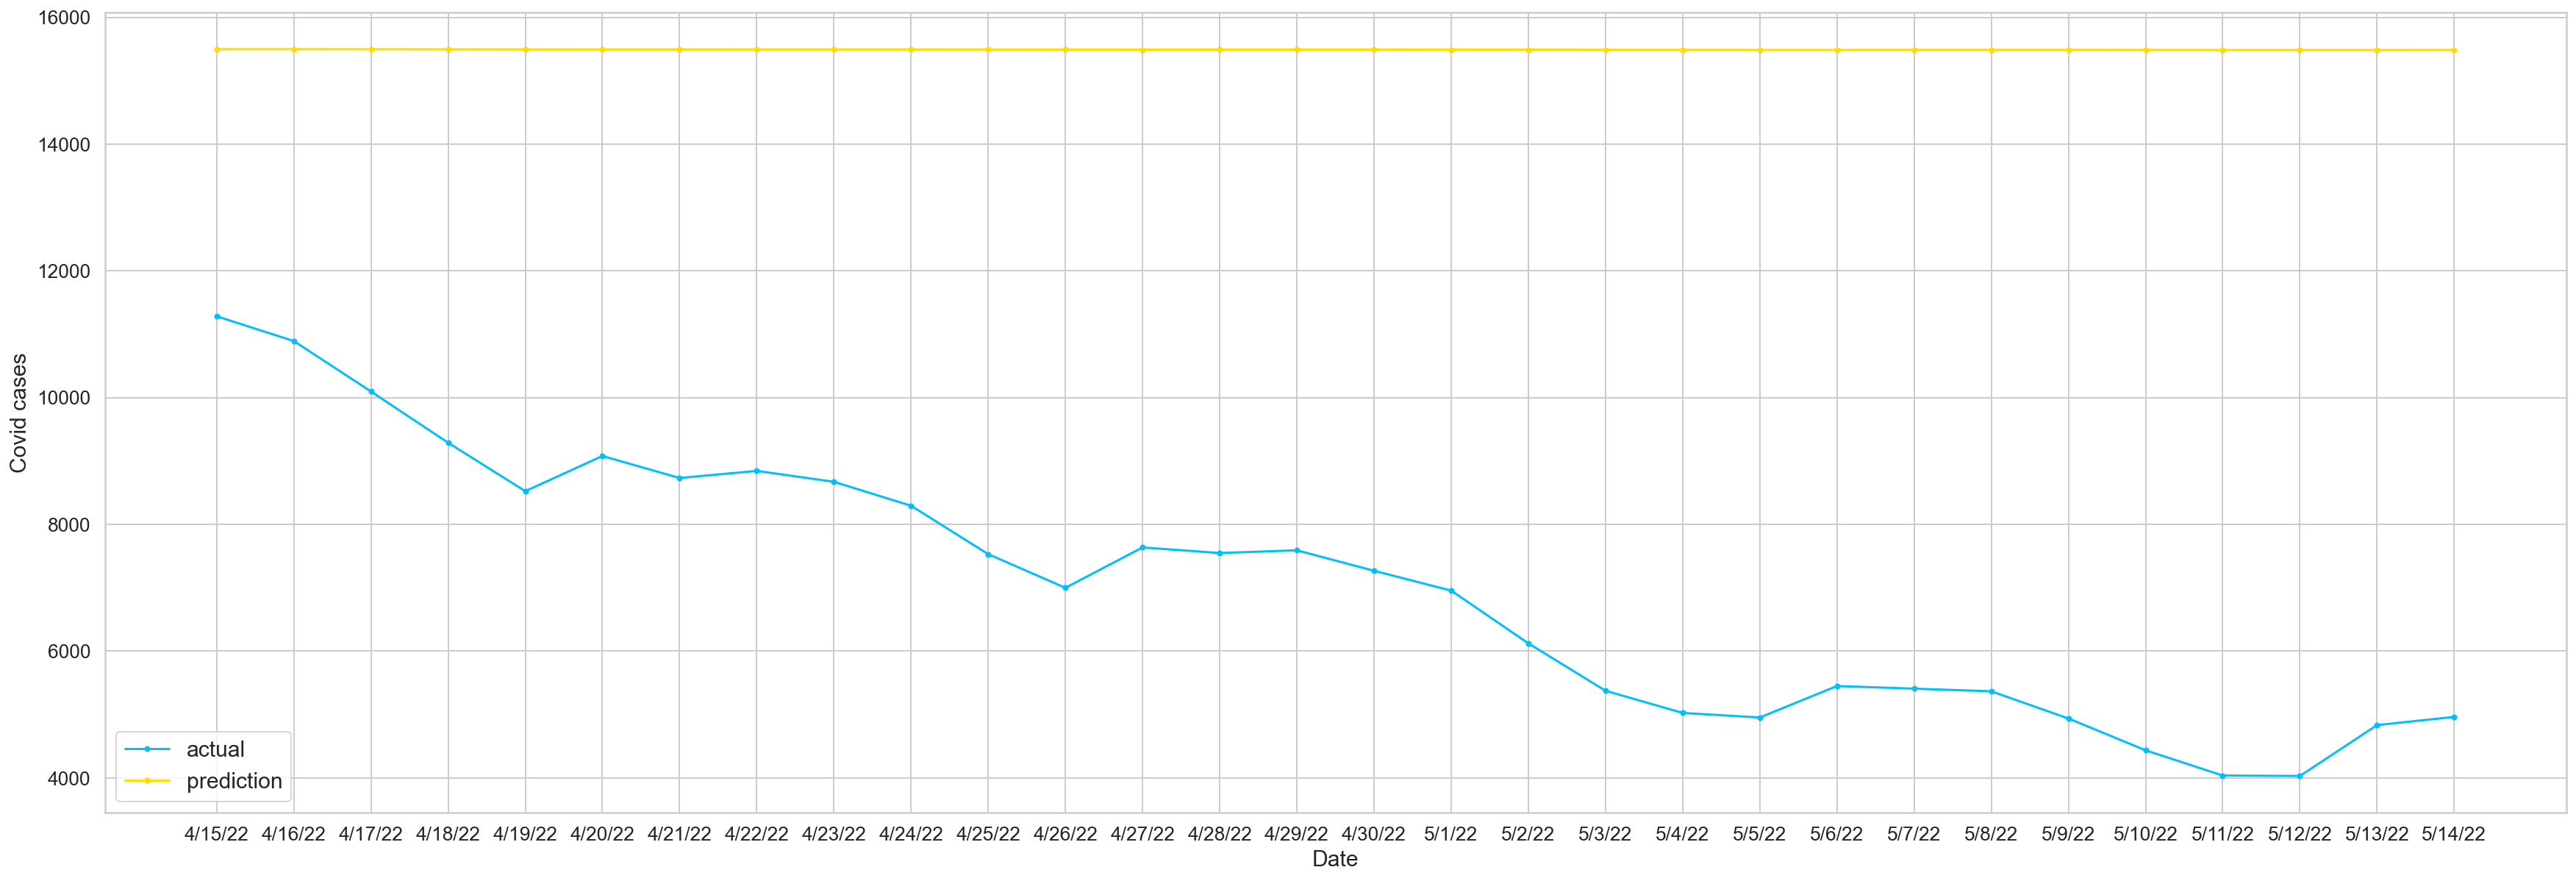

In [102]:
#显示预测结果
plt.plot(df_resample.index[-30:], inv_y[-30:], marker='.', label="actual")
plt.plot(df_resample.index[-30:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()

In [103]:
true_cases=inv_y
predicted_cases=inv_yhat
predicted_cases

array([15497.73175689, 15497.96075847, 15497.1788386 , 15495.59240001,
       15493.97884281, 15492.45417438, 15493.56302415, 15492.86848646,
       15493.09447486, 15492.74645272, 15491.99617122, 15490.47300939,
       15489.41237048, 15490.68393189, 15490.50916753, 15490.59202994,
       15489.9472097 , 15489.32348171, 15487.66623342, 15486.17621655,
       15485.47866568, 15485.33553969, 15486.32235572, 15486.24250648,
       15486.15663089, 15485.29938155, 15484.30503257, 15483.50804681,
       15483.4944875 , 15485.09599198])

In [104]:

# MSE = np.linalg.norm(true_cases-predicted_cases, ord=2)**2/len(true_cases)

RMSE = np.linalg.norm(true_cases-predicted_cases, ord=2)/len(true_cases)**0.5

NRMSE=RMSE/(np.max(true_cases)-np.min(true_cases))

# MAE = np.linalg.norm(true_cases-predicted_cases, ord=1)/len(true_cases)

MAPE=100 * np.mean(np.abs(true_cases-predicted_cases)) / np.mean(true_cases) 

SMAPE=200 * np.mean(np.abs(true_cases-predicted_cases) / (np.abs(true_cases) + np.abs(predicted_cases))) 


RMSE = round(RMSE,4)

NRMSE = round(NRMSE,4)

MAPE = round(MAPE,4)

SMAPE = round(SMAPE,4)

summary=[RMSE,NRMSE,MAPE,SMAPE]

summary

[8723.8057, 1.2026, 121.1392, 77.6614]